## Kaggle Retinal Lesions Segmentation

### Train labels

 Loading the dataset

In [27]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive, rmtree

import pandas as pd
import numpy as np
import cv2
import os

In [28]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        rmtree(directory)
    os.mkdir(directory)

In [29]:
DS_BASE_PATH = 'Data'
DB_PATH = 'DB'
reset_path(DB_PATH)

In [30]:
filename = 'retinal-lesions-v20191227'
ARCHIVE_FILE_PATH = os.path.join(DS_BASE_PATH, f'{filename}.zip')

if os.path.exists(os.path.join(DS_BASE_PATH, filename)):
    rmtree(os.path.join(DS_BASE_PATH, filename))
unpack_archive(ARCHIVE_FILE_PATH, DS_BASE_PATH)

grading_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'dr_grades.csv'])
grading_orig = pd.read_csv(grading_csv_path)
grading_orig.dropna()

segmentation_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'segmentation_metadata.csv'])
segmentation_orig = pd.read_csv(segmentation_csv_path)
segmentation_orig.dropna()

display(grading_orig)
display(segmentation_orig)

,image id,kaggle label,our label
0,7384_right,2,2
1,27099_left,3,2
2,25531_right,2,2
3,34701_right,2,2
4,3166_right,2,1
...,...,...,...
1588,26615_right,2,2
1589,30283_left,2,2
1590,16602_right,2,1
1591,42897_left,2,2


,name,microaneurysm,retinal_hemorrhage,hard_exudate,cotton_wool_spots,neovascularization,vitreous_hemorrhage,preretinal_hemorrhage,fibrous_proliferation
0,10037_left,1,1,0,0,0,0,0,0
1,10047_right,1,1,1,0,0,0,0,0
2,1008_right,1,1,1,1,0,0,0,0
3,10091_right,1,1,1,0,0,0,0,0
4,10105_right,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1570,9893_right,1,1,1,0,0,0,0,0
1571,9944_left,1,0,0,0,0,0,0,0
1572,9990_right,1,1,0,0,0,0,0,0
1573,99_right,1,1,1,0,0,0,0,0


**NOTA MILTON**: Se debe de dividir las imágenes en training/val/test por la cantidad de lesiones, no por la cantidad de imágenes

In [44]:
import xmltodict

path = 'Data/retinal-lesions-v20191227/lesion_segs_896x896/localizacion'
columns = ['retinal_hemorrhage']
# lesion_file_dict = {}
dataset = {}
counts = {}

for idx, col in enumerate(segmentation_orig.columns[1:]):
    files = [f for f in os.listdir(path) if col in f]

    # display(files)

    elements = 0

    for f in files:
        img = f.split('__')[0]
        p = os.path.join(path, f)
        
        if img not in dataset.keys():
            dataset[img] = {}

        # if img not in lesion_file_dict.keys():
        #     lesion_file_dict[img] = {
        #         'name': img
        #     }

        with open(p) as fd:
            xml = xmltodict.parse(fd.read())
            lesions = len(xml['annotation']['object'])
            
            elements += lesions
            # lesion_file_dict[img][col] = lesions
            if col in columns:
                dataset[img][col] = xml['annotation']['object']
        
    counts[idx] = {
        'lesion':col,
        'count': elements
    }
    # display(f'{col}: {elements}')
display(dataset)
counts_df = pd.DataFrame(counts).T
display(counts_df)

{'1277_left': {},
 '1369_right': {'retinal_hemorrhage': {'name': 'retinal hemorrhage',
   'pose': 'Unspecified',
   'truncated': '0',
   'difficult': '0',
   'bndbox': {'xmin': '502', 'ymin': '589', 'xmax': '533', 'ymax': '627'}}},
 '534_left': {'retinal_hemorrhage': [{'name': 'retinal hemorrhage',
    'pose': 'Unspecified',
    'truncated': '1',
    'difficult': '0',
    'bndbox': {'xmin': '1', 'ymin': '380', 'xmax': '40', 'ymax': '426'}},
   {'name': 'retinal hemorrhage',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '670', 'ymin': '230', 'xmax': '718', 'ymax': '271'}},
   {'name': 'retinal hemorrhage',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '681', 'ymin': '627', 'xmax': '731', 'ymax': '680'}}]},
 '508_right': {'retinal_hemorrhage': [{'name': 'retinal hemorrhage',
    'pose': 'Unspecified',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '209', 'ymin': '347', 'xma

,lesion,count
0,microaneurysm,449
1,retinal_hemorrhage,343
2,hard_exudate,93
3,cotton_wool_spots,62
4,neovascularization,15
5,vitreous_hemorrhage,0
6,preretinal_hemorrhage,0
7,fibrous_proliferation,0


/tmp/ipykernel_3760/4124224523.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts_df['lesion'])


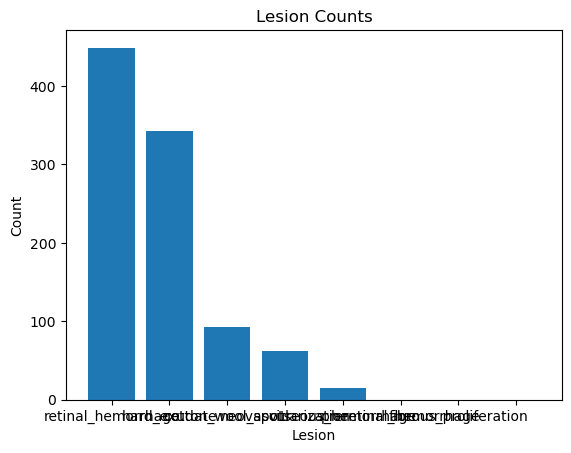

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Set the x-axis labels to the lesion names
ax.set_xticklabels(counts_df['lesion'])

# Create a bar plot with the 'count' column and color each bar based on the 'color' column
ax.bar(
    counts_df.index, 
    counts_df['count'], 
    # color=counts_df['color']
)

# Set the title and axis labels
ax.set_title('Lesion Counts')
ax.set_xlabel('Lesion')
ax.set_ylabel('Count')

plt.show()

# This code should create a bar plot with different colors for each lesion. The x-axis labels will be set to the lesion names, and the bars will be colored according to the 'color' column in the DataFrame. The plot will also have a title and axis labels.


In [32]:
lesion_map = {l:idx for idx, l in enumerate(columns)}

print(lesion_map)

yolo_dataset = {}

for img in dataset.keys():
    for lesion in dataset[img].keys():
        if lesion in columns:
            objs = dataset[img][lesion]
        
            if not (type(objs) == list):
                objs = [objs]
                
            for obj in objs:
                bndbox= obj['bndbox']

                bndbox = [int(v) for v in list(bndbox.values())]
                # print(bndbox)
                xcenter = (bndbox[2]+bndbox[0])/2
                ycenter = (bndbox[3]+bndbox[1])/2
                width = bndbox[2]-bndbox[0]
                height = bndbox[3]-bndbox[1]
                
                bndbox = np.array([xcenter, ycenter, width, height])
                # print(bndbox)
                bndbox = bndbox / 896
                bndbox = [str(b) for b in bndbox.tolist()]

                lession_class = lesion_map[lesion]
                dp = [str(lession_class)]
                dp.extend(bndbox)
                dp = ' '.join(dp)

                if img not in yolo_dataset.keys():
                    yolo_dataset[img] = []
                
                yolo_dataset[img].append(dp)
yolo_dataset

{'retinal_hemorrhage': 0}


{'1369_right': ['0 0.5775669642857143 0.6785714285714286 0.03459821428571429 0.04241071428571429'],
 '534_left': ['0 0.022879464285714284 0.4497767857142857 0.04352678571428571 0.05133928571428571',
  '0 0.7745535714285714 0.27957589285714285 0.05357142857142857 0.04575892857142857',
  '0 0.7879464285714286 0.7293526785714286 0.05580357142857143 0.05915178571428571'],
 '508_right': ['0 0.25613839285714285 0.4095982142857143 0.04575892857142857 0.044642857142857144',
  '0 0.36328125 0.44810267857142855 0.04575892857142857 0.05915178571428571',
  '0 0.47879464285714285 0.7338169642857143 0.10044642857142858 0.056919642857142856',
  '0 0.53515625 0.82421875 0.041294642857142856 0.04352678571428571',
  '0 0.7946428571428571 0.6383928571428571 0.07142857142857142 0.08035714285714286',
  '0 0.890625 0.7059151785714286 0.09151785714285714 0.07700892857142858',
  '0 0.8850446428571429 0.5625 0.060267857142857144 0.049107142857142856',
  '0 0.8694196428571429 0.4732142857142857 0.05357142857142

In [33]:
yolo_df = pd.DataFrame(yolo_dataset.keys(), columns=['image'])
yolo_df

,image
0,1369_right
1,534_left
2,508_right
3,539_right
4,945_right
5,99_right
6,1413_left
7,317_left
8,1532_left
9,229_right


In [34]:
train_idx, remain_idx, train_y, remain_y = train_test_split(
    yolo_df.index,
    yolo_df['image'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

val_idx, test_idx, val_y, test_y = train_test_split(
    remain_idx,
    remain_y,
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

In [35]:
display(yolo_df.iloc[train_idx].shape)
display(yolo_df.iloc[val_idx].shape)
display(yolo_df.iloc[test_idx].shape)

(33, 1)

(4, 1)

(5, 1)

In [36]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [37]:
IMG_PATH = 'Data/retinal-lesions-v20191227/images_896x896'

set_paths = [
    (yolo_df.iloc[train_idx]['image'].to_list(), 'train'),
    (yolo_df.iloc[val_idx]['image'].to_list(), 'val'),
    (yolo_df.iloc[test_idx]['image'].to_list(), 'test')
]

def create_db_path(base:str=DB_PATH, path:str=None):
    
    if path != None:
        path =  os.path.join(base, path)
        if not os.path.exists(path):
            print(f'Creating {path}')
            os.mkdir(path)
        return path
    else:
        print("Empty path, therefore not created")


im_path = create_db_path(path='images')
label_path = create_db_path(path='labels')

for sp in set_paths:
    for j, img in enumerate(yolo_dataset.keys()):
        current_set, set_path = sp
        if j==0:
            print(f'Subset:{set_path}')
        
        if img in current_set:
            
            im_orig_path = os.path.join(IMG_PATH, img + '.jpg')
            im_dest_path = create_db_path(
                                    base=im_path,
                                    path=set_path)
            im_dest_path = os.path.join(im_dest_path, img + '.jpg')
            lb_path = create_db_path(
                                    base=label_path,
                                    path=set_path)
            lb_path = os.path.join(lb_path, img+'.txt')
            
            copy(im_orig_path, im_dest_path)
            print(f'[{j}/{len(yolo_dataset.keys())}] {im_dest_path}, {lb_path}')
            clahe_image(im_dest_path)
            
            for obj in yolo_dataset[img]:
                print(obj)
                with open(file=lb_path, mode='a') as f:
                    f.write(obj+'\n')



# for sp in set_paths:
#     for j, idx in enumerate(yolo_dataset.keys()):
#         current_set, set_path = sp
#         if j==0:
#             print(f'Subset:{set_path}')
#         if idx in current_set:

#             im_orig_path = os.path.join(IMG_PATH, yolo_dataset[idx]['name']+'.jpg')
            

#             if not os.path.exists(im_dest_path):
            
            
            

Creating DB/images
Creating DB/labels
Subset:train
Creating DB/images/train
Creating DB/labels/train
[0/42] DB/images/train/1369_right.jpg, DB/labels/train/1369_right.txt
0 0.5775669642857143 0.6785714285714286 0.03459821428571429 0.04241071428571429
[1/42] DB/images/train/534_left.jpg, DB/labels/train/534_left.txt
0 0.022879464285714284 0.4497767857142857 0.04352678571428571 0.05133928571428571
0 0.7745535714285714 0.27957589285714285 0.05357142857142857 0.04575892857142857
0 0.7879464285714286 0.7293526785714286 0.05580357142857143 0.05915178571428571
[2/42] DB/images/train/508_right.jpg, DB/labels/train/508_right.txt
0 0.25613839285714285 0.4095982142857143 0.04575892857142857 0.044642857142857144
0 0.36328125 0.44810267857142855 0.04575892857142857 0.05915178571428571
0 0.47879464285714285 0.7338169642857143 0.10044642857142858 0.056919642857142856
0 0.53515625 0.82421875 0.041294642857142856 0.04352678571428571
0 0.7946428571428571 0.6383928571428571 0.07142857142857142 0.08035714

In [38]:
import yaml

# Define the dataset directory and image subdirectories
dataset_root = DB_PATH
train_images_dir = "images/train"
val_images_dir = "images/val"
test_images_dir = "images/test"

# Define the dataset configuration
dataset_config = {
    "path": dataset_root,
    "train": train_images_dir,
    "val": val_images_dir,
    "test": test_images_dir,
    "names": {v:k for k,v in lesion_map.items()}
}

# Write the configuration to a YAML file
yaml_filepath = os.path.join(DB_PATH,"retinal_lesion.yaml")
with open(yaml_filepath, "w") as f:
    yaml.dump(dataset_config, f, sort_keys=False)

In [39]:
from shutil import make_archive

make_archive(
    base_name=f'DB-{columns[0]}',
    format='zip',
    base_dir=DB_PATH
)

'DB-retinal_hemorrhage.zip'